In [97]:
import numpy as np 
import pandas as pd 
import itertools
import sys
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process import GaussianProcessRegressor

# Direct to UCB_opt_tools module 
sys.path.append('../../')
from UCB_opt_tools import UCB_opt
from UCB_opt_tools import UCB_batch_mode


import warnings

warnings.filterwarnings('ignore')

# Load the data

In [98]:
df = pd.read_excel('data/RL08_Relabeled.xlsx', index_col=0)

# Get rid of unnecessary columns
df = df[['Final_Label', 'Block_seq', 'Sum C6-C16', 'AA_seq']]

# Fill NaNs in 'Block_seq' and AA-seq
df['Block_seq'].fillna('-', inplace=True)
df['AA_seq'].fillna('-', inplace=True)


# Rename titer column 
df = df.rename(columns={'Sum C6-C16':'titer', 'Final_Label':'name'})

df.head()

,name,Block_seq,titer,AA_seq
0,ATR-23,A-ATBBBAAT,3.623375,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...
1,ATR-23,A-ATBBBAAT,4.160071,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...
2,ATR-23,A-ATBBBAAT,3.672095,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...
3,Empty Vector,-,1.268835,-
4,Empty Vector,-,1.109339,-


# Cleaning and preprocessing

In [99]:
# Average the data
df_avg = df.groupby(by=['name','Block_seq', 'AA_seq']).mean().reset_index()
df_avg

,name,Block_seq,AA_seq,titer
0,ATR-01,A-ATAATTBB,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,1.528668
1,ATR-02,A-TATTTTAB,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,0.809306
2,ATR-03,A-TTTTBTBA,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,0.932477
3,ATR-04,A-ATTBAATB,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,0.595051
4,ATR-05,A-ABTATTTA,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,0.917234
...,...,...,...,...
99,MA-ACR (Parent A),A-AAAAAAAA,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,11.079517
100,MB-ACR,B-BBBBBBBB,NYFVTGGTGFIGRFLIAKLLARGAIVHVLVREQSVQKLADLREKLG...,26.477074
101,MT-ACR,T-tTTTTTT,QYFVTGATGFIGKRLVRKLLDRRGSTVHFLLRPESERKLPELLAYW...,4.012505
102,Parent B (Fusion A-B),A-BBBBBBBB,NYFLTGGTGFIGRFLVEKLLARGGTVYVLVREQSQDKLERLRERWG...,36.675911


In [100]:
# Clean up the data frame

df_ucb = df_avg[['name', 'Block_seq', 'titer']]

# Take the log of the titer
df_ucb['log_titer'] = np.log(df_ucb['titer'])

# Drop out instances that are problematic ()
df_ucb = df_ucb[(~df_ucb['name'].str.contains(r'M[TB]-ACR')) & (~df_ucb['name'].str.contains(r'^Fusion'))].reset_index(drop=True) 

# Reformat the sequence column to make it easier to encode 
df_ucb['seq'] = df_ucb['Block_seq'].str.extract(r'(.)-') + df_ucb['Block_seq'].str.extract(r'-(.+)')
df_ucb.drop('Block_seq', axis=1)
df_ucb = df_ucb.dropna().reset_index(drop=True)
df_ucb

,name,Block_seq,titer,log_titer,seq
0,ATR-01,A-ATAATTBB,1.528668,0.424397,AATAATTBB
1,ATR-02,A-TATTTTAB,0.809306,-0.211578,ATATTTTAB
2,ATR-03,A-TTTTBTBA,0.932477,-0.069911,ATTTTBTBA
3,ATR-04,A-ATTBAATB,0.595051,-0.519107,AATTBAATB
4,ATR-05,A-ABTATTTA,0.917234,-0.086393,AABTATTTA
...,...,...,...,...,...
91,ATR-92,A-ABBBAAAB,35.281228,3.563351,AABBBAAAB
92,ATR-93,A-BTBBATAB,34.566492,3.542885,ABTBBATAB
93,MA-ACR (Parent A),A-AAAAAAAA,11.079517,2.405098,AAAAAAAAA
94,Parent B (Fusion A-B),A-BBBBBBBB,36.675911,3.602120,ABBBBBBBB


# Encode the data 

In [101]:
df_encode = df_ucb['seq'].str.split(r'',expand=True).drop([0,10],axis=1)
df_encode

ohc = OneHotEncoder()

df_ohc = pd.DataFrame(ohc.fit_transform(df_encode).toarray())

# Data Walk (Normal UCB method)


Iteration 0: ABBBBBAAB, 3.9
Iteration 1: ABBBBBATB, 0.3
Iteration 2: ABBBBBTAB, 3.0
Iteration 3: ABBBBAAAB, 3.7
Iteration 4: AABBBBAAB, 3.8
Iteration 5: AABBBAAAB, 3.6
Iteration 6: AABBBBABB, 3.6
Iteration 7: AABBBBTBB, 3.1
Iteration 8: ABABBBAAB, 3.5
Iteration 9: AAABBBAAB, 3.6
Iteration 10: AAABBAAAB, 3.7
Iteration 11: AAABBBABB, 3.6
Iteration 12: ABABBBABB, 3.6
Iteration 13: ABTBBBAAB, 4.0
Iteration 14: AATBBBAAB, 3.8
Iteration 15: AATBBAAAB, 4.0
Iteration 16: ABTBBAAAB, 4.1


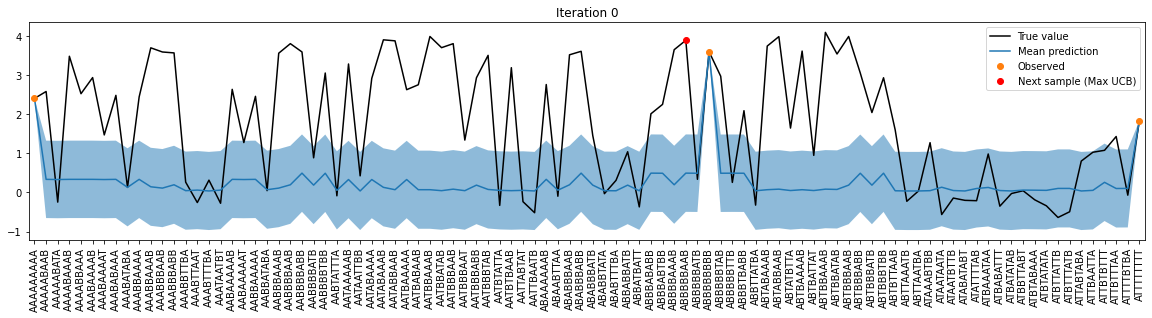

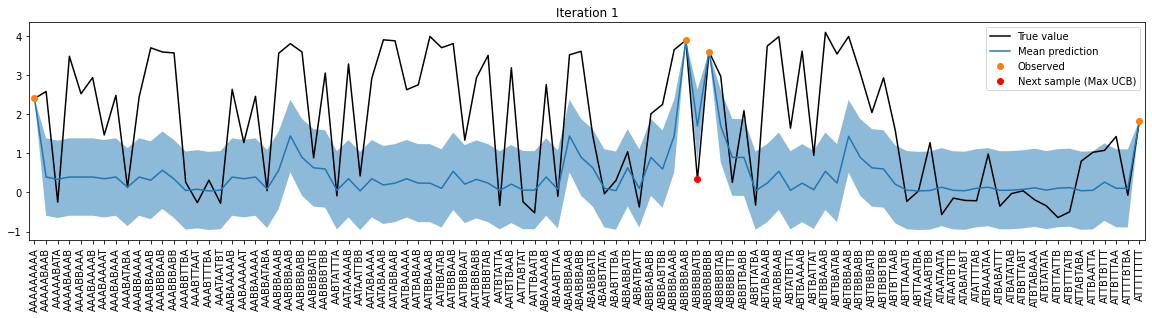

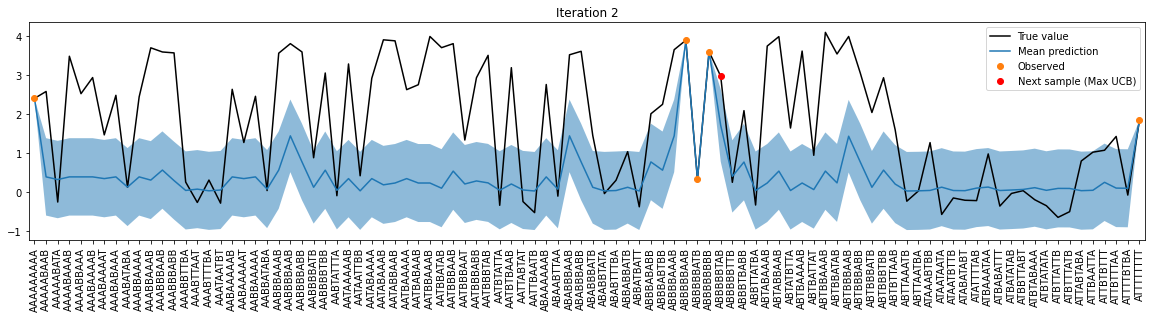

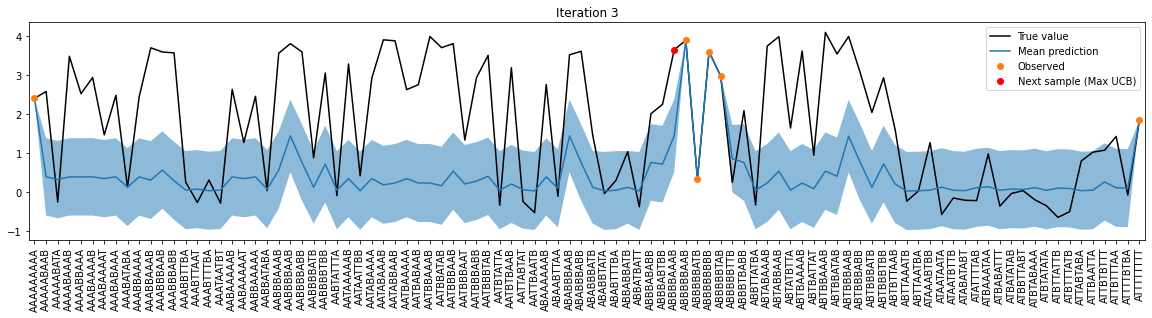

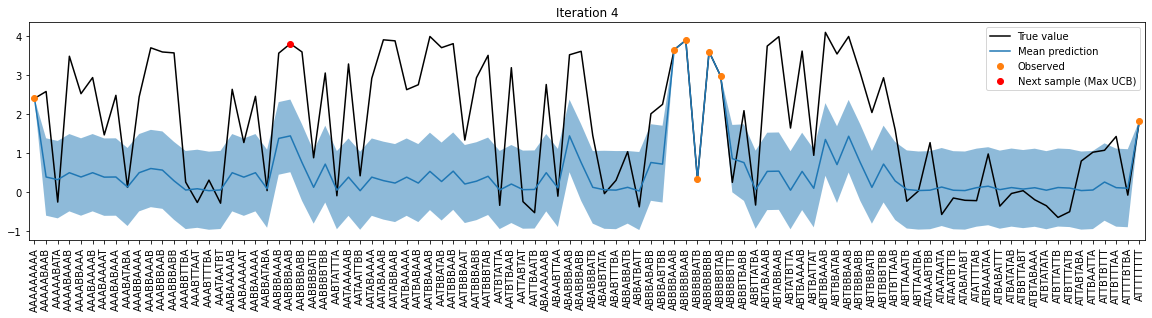

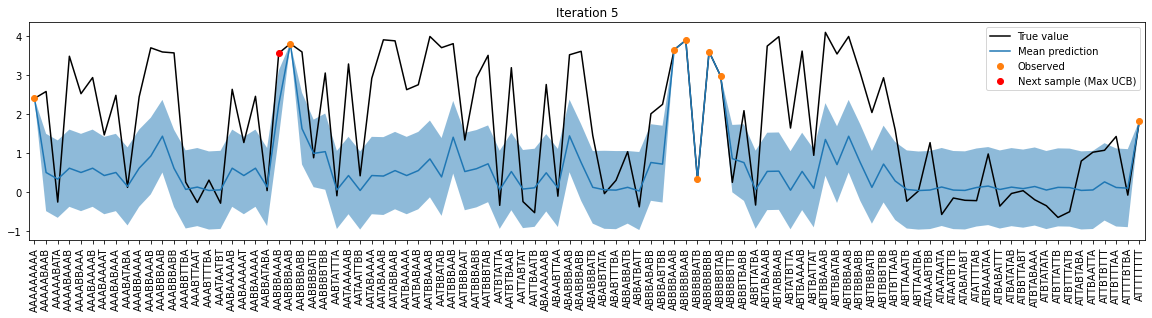

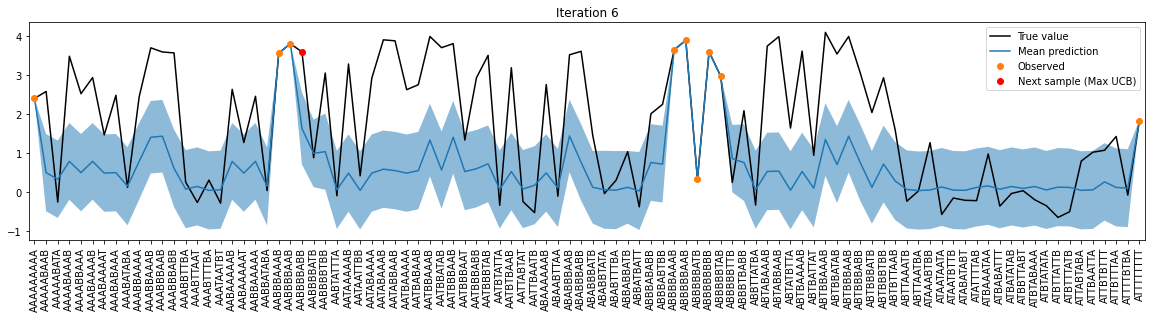

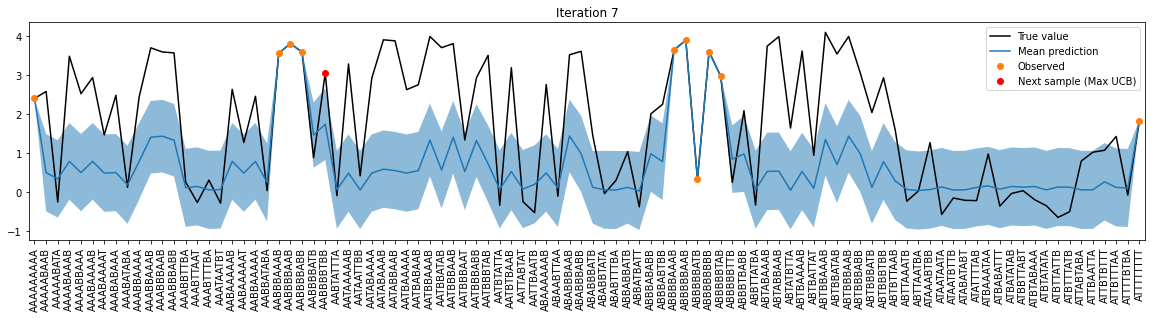

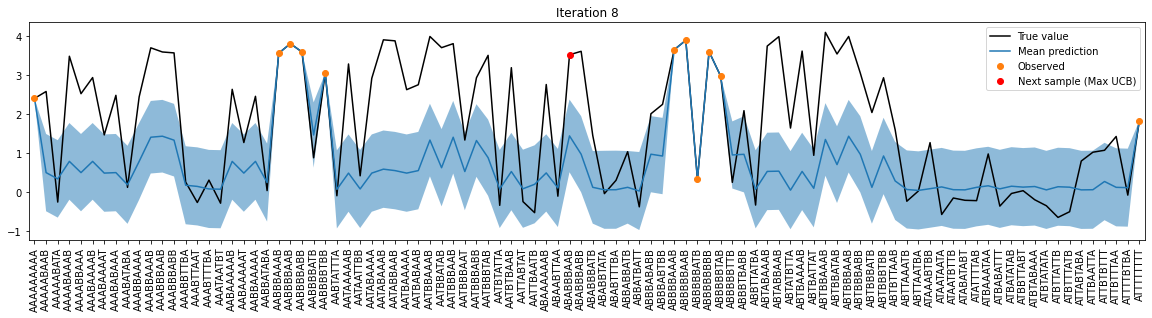

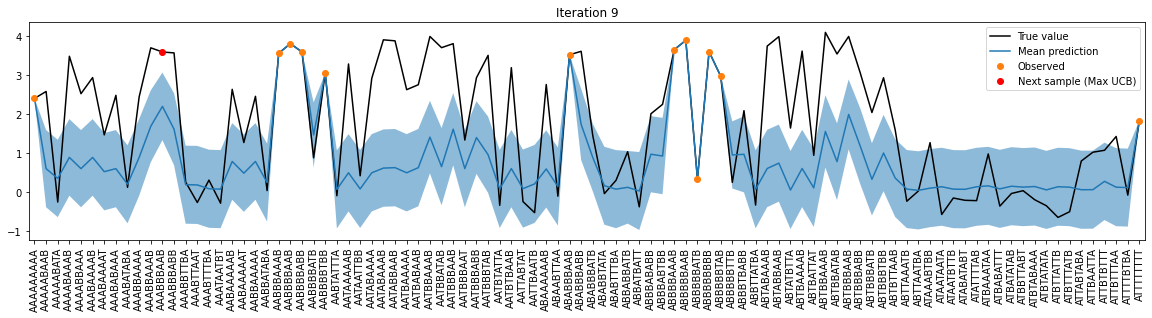

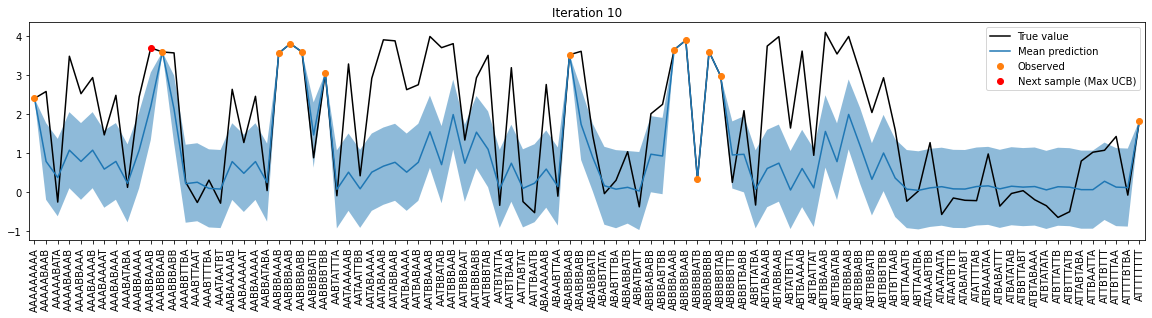

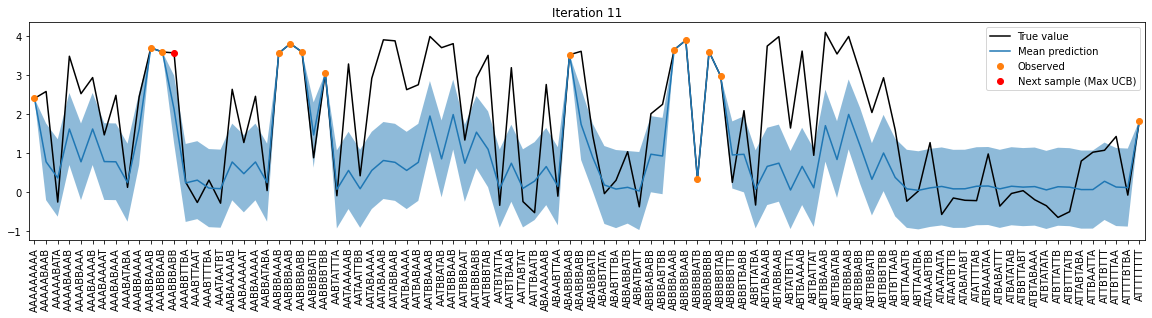

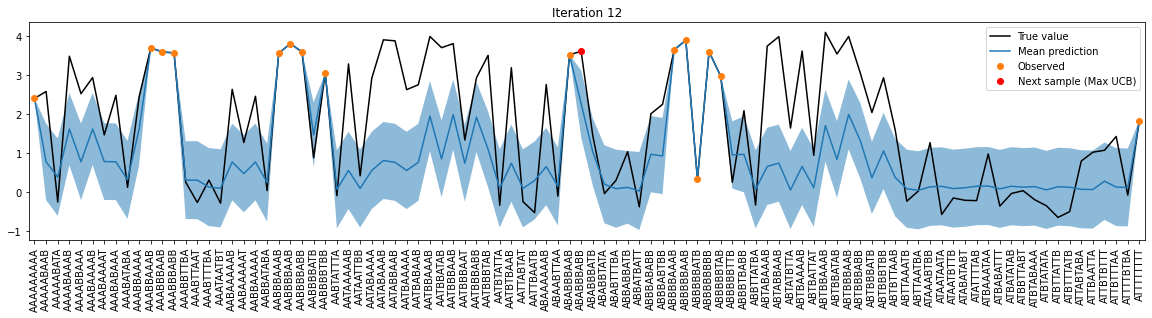

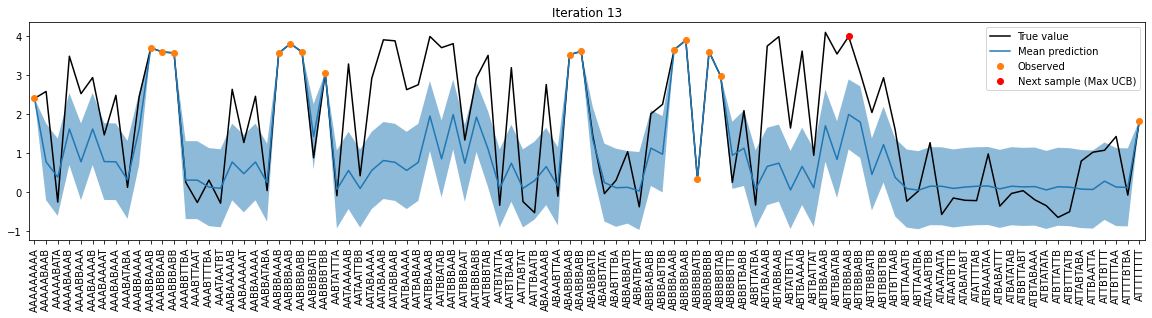

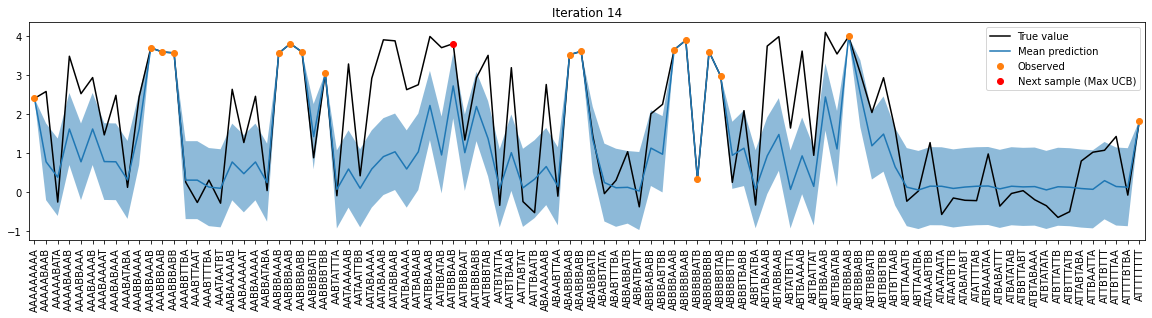

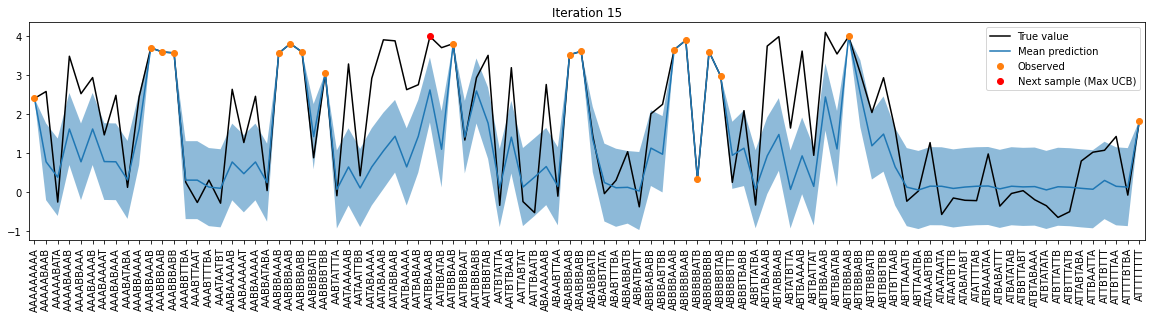

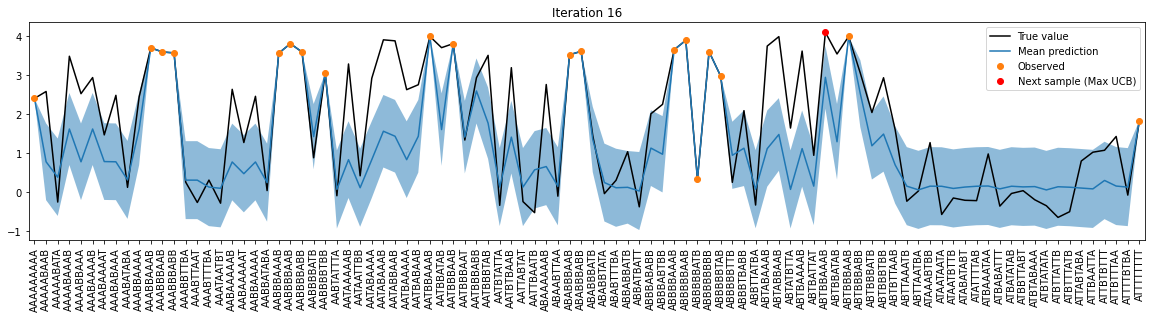

In [106]:
# Specify a set of 3 proteins to use as a starting point (in this case, the three parental enzymes)
df_start = df_ucb[df_ucb['name'].str.contains('Parent')]
df_start_locs = list(df_start.index)

# Get the initial one-hot encodings
X_start = df_ohc.loc[df_start_locs]

# Get the initial experimental measurements
y_start = df_start['log_titer']

# Set up the initial prediction space 
X_pred_start = df_ohc.drop(df_start_locs)

# Copy the start variables to a variable that can be updated 
X_walk = X_start.copy().to_numpy()
y_walk = list(y_start)
X_pred_walk = X_pred_start.copy()

# Start the walk through 
iters = 0 
y_actual = 0 

# Stop when reaching the actual optimum (since this is a simulated walk through an existing dataset)
y_optimum = df_ucb['log_titer'].max()

while y_actual < y_optimum: #and iters <=12:
    # Determine the next point to sample 
    X_pred_opt, y_pred_opt, y_preds, std_preds, ind = UCB_opt(X_walk, y_walk, X_pred_walk,num_std=1)
    block_seq = ''.join(ohc.inverse_transform(X_pred_opt.reshape(1, -1))[0])

    # Plot the progress of the model
    y_model = list(y_preds) + y_walk
    std_model = list(std_preds) + list(np.zeros(len(y_walk)))
    X_model = np.vstack([X_pred_walk, X_walk])
    seq_model = [''.join(ohc.inverse_transform(X.reshape(1, -1))[0]) for X in X_model]

    df_plot = pd.DataFrame(list(zip(y_model, std_model)), index = seq_model, columns = ['mean', 'std'])

    #unnecessary to do this inside the list, but safer to make sure that it's working right 
    df_plot['true'] = [float(df_ucb[df_ucb['seq']==seq]['log_titer']) for seq in df_plot.index] 

    df_plot = df_plot.sort_index()
    df_plot['x'] = np.arange(len(df_plot))

    # Make the plot 
    plt.figure(figsize=(20,4))
    plt.plot(df_plot['x'], df_plot['true'], 'k-', label='True value')
    plt.plot(df_plot['x'], df_plot['mean'], '-', label='Mean prediction')
    plt.fill_between(df_plot['x'], df_plot['mean']-df_plot['std'], df_plot['mean']+df_plot['std'], alpha=0.5)
    plt.plot(df_plot[df_plot['std']==0]['x'], df_plot[df_plot['std']==0]['mean'], 'o', label='Observed')
    plt.plot(df_plot.loc[block_seq]['x'], df_plot.loc[block_seq]['true'], 'ro', label='Next sample (Max UCB)')


    plt.xticks(df_plot['x'], df_plot.index, rotation=90)
    plt.margins(x=0.005)
    plt.title(f'Iteration {iters}')
    plt.legend()


    # Do an 'experiment' to reveal the true value of that point
    y_actual = float(df_ucb[df_ucb['seq']==block_seq]['log_titer'])

    # Update X_walk, y_walk, and X_pred_walk
    y_walk.append(y_actual)
    X_walk = np.vstack([X_walk, X_pred_opt])
    X_pred_walk = X_pred_walk.drop(X_pred_walk.iloc[ind].name)

    print(f'Iteration {iters}: {block_seq}, {round(y_actual,1)}')

    iters += 1 

In [103]:
df_plot

,mean,std,true,x
AAAAAAAAA,2.405098,0.000000,2.405098,0
AAAAABAAB,0.749915,0.983444,2.583156,1
AAAAABATA,0.351188,0.991313,-0.247948,2
AAAABAAAB,1.548475,0.929369,3.485031,3
AAAABBAAA,0.749915,0.983444,2.526849,4
...,...,...,...,...
ATTBAATTA,0.082161,0.999797,1.028574,91
ATTBTBTTT,0.278699,0.991553,1.077870,92
ATTBTTTAA,0.150216,0.998811,1.431212,93
ATTTTBTBA,0.123902,0.998844,-0.069911,94


# Batch mode walkthrough 

In [104]:
df_start = df_ucb[df_ucb['name'].str.contains('Parent')]
df_start_locs = list(df_start.index)

X_start = df_ohc.loc[df_start_locs]
y_start = df_start['titer']
X_pred_start = df_ohc.drop(df_start_locs)


# Copy the start variables to a variable that can be updated 
X_walk = X_start.copy().to_numpy()
y_walk = list(y_start)
X_pred_walk = X_pred_start.copy()

iters = 0 

while iters <= 11: 
    X_pred_opts, y_preds, inds = UCB_batch_mode(X_walk, y_walk, X_pred_walk, batchsize=5)
    block_seqs = [] 
    for x in X_pred_opts:
        block_seqs.append(''.join(ohc.inverse_transform(x.reshape(1, -1))[0]))

    # Update Variables

    X_walk = X_pred_opts

    # Do 'experiments' to unmask 
    y_actuals = [float(df_ucb[df_ucb['seq']==block_seq]['titer']) for block_seq in block_seqs]
    y_walk = y_actuals

    # Remove 
    for ind in list(set(inds)):
        print(ind)
        X_pred_walk = X_pred_walk.drop(X_pred_walk.iloc[ind].name)

    #TODO: FIX the output
    # print(f'Iteration {iters}: {block_seqs[-1]}, {round(y_walk[-1],1)}')


    iters += 1

54
56
58
61
62
56
57
57
62
63
62
72
65
60
71
39
60
64
60
63
62
